# State abstraction and equivalence

Our task can be represented in classical Markov Decision Process fashion. Our tasks is characterized by the state space $S$, the action space $A$, the reward function (or utility) $U$ and the transition function $P$. In our experiment, the state space has the following dimensions:
- $E_t$: energy at time $t$
- $O_t$: offer at time $t$
- $CC_t$: the energy cost in the first segment at time $t$
- $FC_t$: the energy cost in the second segment at time $t$

Our action space $A$ contains two separate actions, either accept or reject. In the previous notebook, the transition probabilities were written as a series of if statements as to return only the states that have a non-zero probability. But in fact, the full transitional probability function should map to each single state the probability of landing in any other possible state, given the action that was taken. In other words, the transitional probability function is $P:S\times A \times S$. In other words, say we are in the state $S_t = [E_t=3, O_t=2, CC_t=1, FC_t=2]$. The $P(s'|s, a)$ should tell us the probability of landing in state $S_t = [E_t=5, O_t=2, CC_t=1, FC_t=2]$ between 0 and 1 when we take the reward. We know that it's 0 because there is no way to earn 2 energies in one time step. But nonetheless, the full transitional probability matrix would contain that information<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

The last part of our MDP is the reward function or utility $R$, which tells us the immediate reward we get from taken a particular action. In our case, the immediate reward is the offer if we accept and can afford it, otherwise it's zero. 

The key idea behind all state abstraction methods is the following: a state is unique (from a planning perspective) if it leads to different consequences. Or from a different perspective, a state is a sufficient statistic about the environment to predict the future <a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) <a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) <a name="bib_ref-3"></a>[<sup>[3]</sup>](#bib_ref3). If two different states yield the exact same prediction about the future, then they are exactly the same. More formally:

$$
  \forall a \in A =
    \begin{cases}
      R(s_i, a) = R(s_j, a) \\
      P(\cdot|s_i, a) = P(\cdot|s_j, a)
    \end{cases}  
$$

Specifically, what that means is that two states $s_i$ and $s_j$ are the same if they result in the same reward and the probability of landing in any future state when starting from that state are the same.

## $P_{\forall s \in S}(\cdot|s, a)$ in our task

In the previous notebook where we implemented the backward induction method to compute the optimal value and state action value functions, the probability to go from one state to the next was computed on the fly using the `state_transition` function, i.e. for each state we computed the probability to reach other states. Specifically, since everything but the offer is deterministic in our task, we only returned the states that had a non-zero probability of occuring. But in fact, we can compute the full transitional probability matrix we tells us for each state and action, what is the probability to land in any other possible states. We will do so using the flatten rather than nested state space to make things a bit easier to keep track of:

In [328]:
import numpy as np
import itertools

E = [0, 1, 2, 3, 4, 5, 6]  # Energy levels
O = [100, 200, 225, 250, 275, 300, 400]  # Offers
C = [1, 2]  # Costs of accepting a reward
T = [1, 2, 3, 4, 5, 6, 7, 8]  # Number of trials in a segment pair 
A = [0, 1]  # Possible actions: 0 = reject, 1=accept
emax = 6  # Max energy level

# Create a list of all possible states:
# Create the entire state space:
states_flat = list(itertools.product(E, O, C, C, T))
state_to_idx = {state: idx for idx, state in enumerate(states_flat)}
idx_to_state = {idx: state for idx, state in enumerate(states_flat)}

# The transition probability matrix maps to each state the probability to land in every other possible state, given the action one has taken
tp = np.zeros([len(states_flat), len(A), len(states_flat)])
r = np.zeros([len(states_flat), len(A)])

# Loop through each possible state:
for a in A:
    for i, state in enumerate(states_flat):
        # Extract the variables from the current state:
        e, o, cc, fc, t = state
        if t > 4 and a == 1 and e>=fc or t <= 4 and a == 1 and e >= cc:
            r[state_to_idx[state], a] = o
        if t == T[-1]:
            continue
        # Get the transition probability to other possible states:
        if t > 4:
            if a == 1:
                if e >= fc:
                    for o2 in O:
                        tp[state_to_idx[state], a, state_to_idx[e-fc, o2, cc, fc, t+1]] = 1/len(O)
                    r[state_to_idx[state], a] = o
                else:
                    for o2 in O:
                        tp[state_to_idx[state], a, state_to_idx[0, o2, cc, fc, t+1]] = 1/len(O)
            else:
                    for o2 in O:
                        tp[state_to_idx[state], a, state_to_idx[min(emax, e+1), o2, cc, fc, t+1]] = 1/len(O)
        else:  
            if a == 1:
                if e >= cc:
                    for o2 in O:
                        tp[state_to_idx[state], a, state_to_idx[e-cc, o2, cc, fc, t+1]] = 1/len(O)
                        r[state_to_idx[state], a] = o
                else:
                    for o2 in O:
                        tp[state_to_idx[state], a, state_to_idx[0, o2, cc, fc, t+1]] = 1/len(O)
            else:
                    for o2 in O:
                        tp[state_to_idx[state], a, state_to_idx[min(emax, e+1), o2, cc, fc, t+1]] = 1/len(O)


The tp matrix that we have computed above gives us the probability of landing on any other possible state given the action that we take. Intuitively, given the structure of our task, we know that there are only a very limited number of states we can end up in given the current state we are in. In a nutshell, there are only N offers possible states we can reach from a previous state given an action: there is only one possible energy level following a particular state and action, the current and future reward remain the same, and the time will be t+1, and the only thing that is stochastic is the offer, with uniform probability. So from a given state and action, the next state energy, cc, fc and t are fixed, and we have equal probability of landing on each possible reward. So if we plot the TP matrix, we should see that there are only few states that can be reached from a current state, resulting in a rather sparse matrix.

Let's plot the tp matrix to see what it looks like to get a better understanding of the TP in our task:

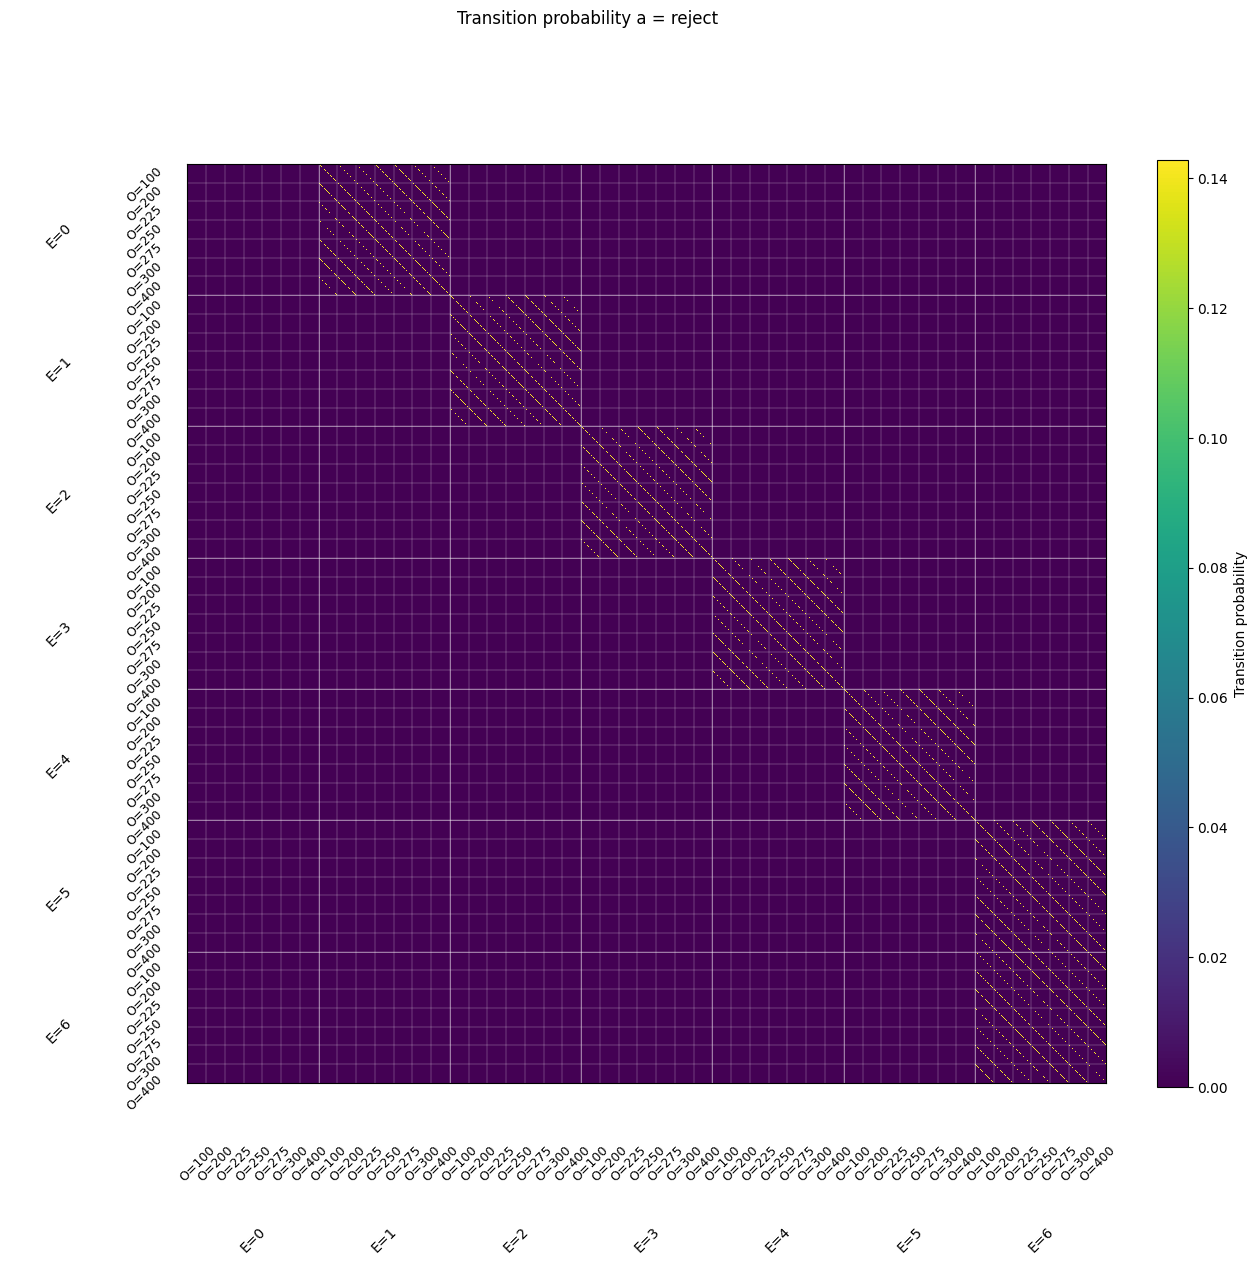

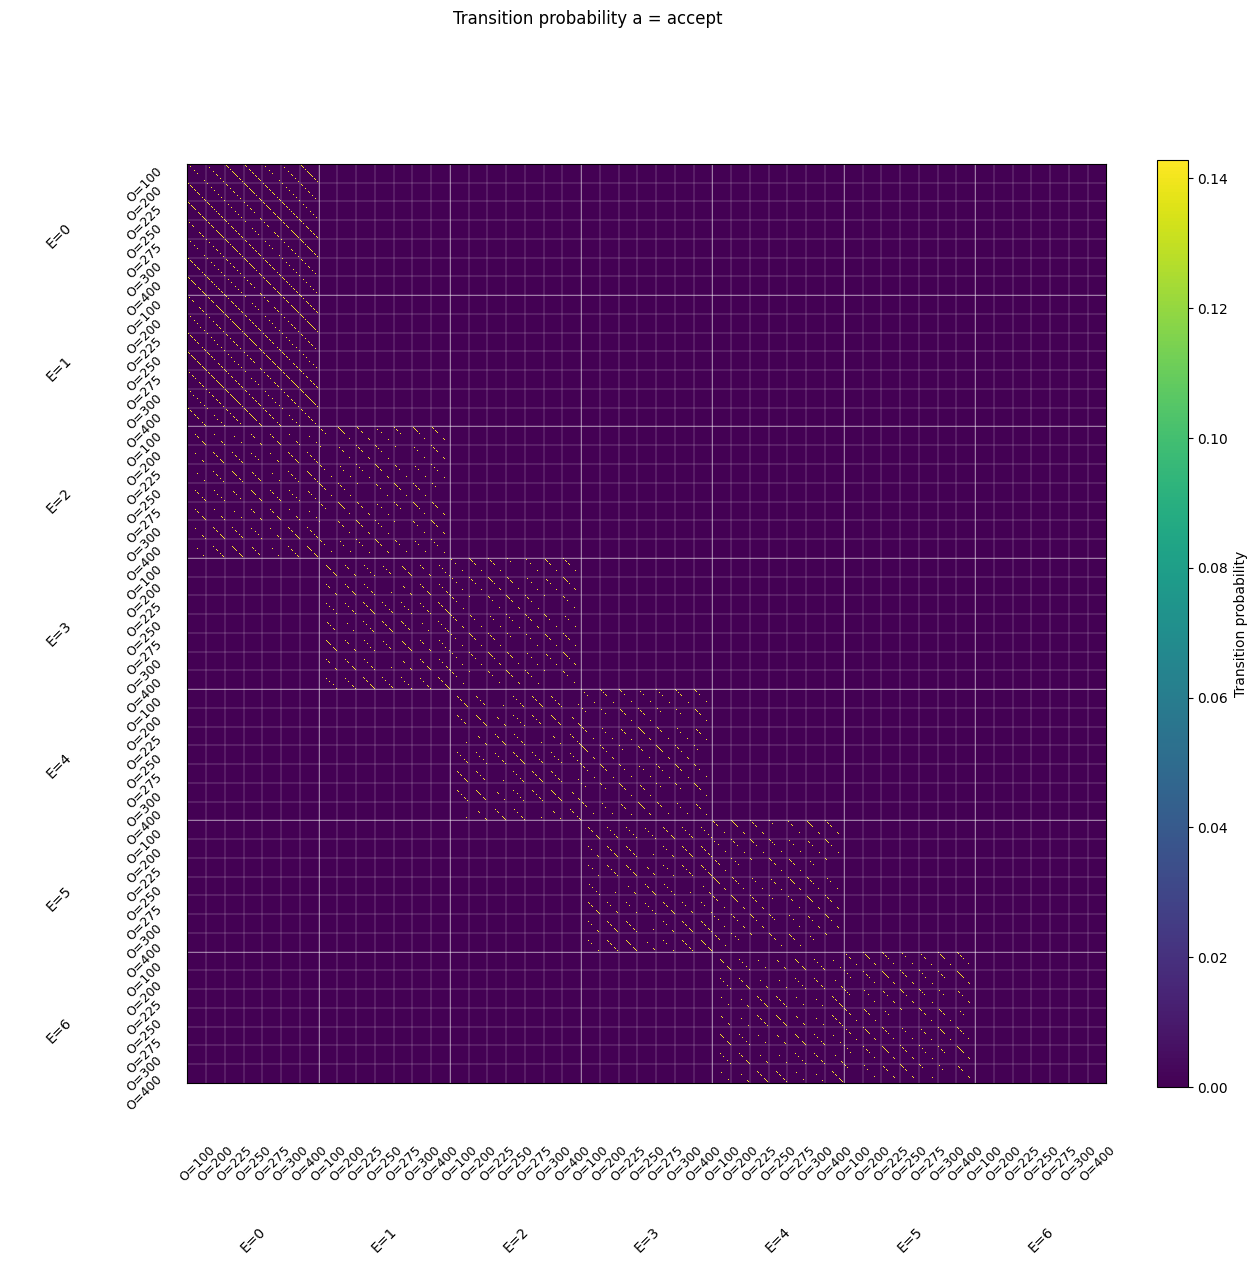

In [329]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Sequence, Tuple

def plot_state_matrix(
        matrix: np.ndarray,
        states: Sequence[Sequence[int]],
        depth: int = 3,
        cmap: str = "viridis",
        max_labels_per_tier: int = 60,
        rotate_x: bool = True,
        fig: Optional[plt.Figure] = None,
        ax: Optional[plt.Axes] = None,
        feature_names: Optional[list] = None,
        cbar_label: Optional[str] = None,

 ) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a state-by-state matrix
    with hierarchical labels. X-axis tiers are placed *below* the heatmap and
    Y-axis tiers to the *left*, with outermost (top-level) labels farthest from
    the heatmap.

    Each tier represents one dimension of the state vector, for example:
    energy, offer, current cost, future cost, or time. The function constructs
    hierarchical labels that visualize how state groups are nested.

    Parameters
    ----------
    matrix : np.ndarray
        2D square array of shape (N, N) representing state-to-state distances
        or correspondences.
    states : Sequence[Sequence[int]]
        Array-like of shape (N, D) where each row represents one state.
        Columns are typically ordered as [E, O, CC, FC, T].
        Must be lexicographically sorted along these dimensions for proper
        block structure.
    depth : int, optional
        Number of hierarchical levels (1–5) to display. The first `depth`
        features in `states` are used. Default is 3.
    cmap : str, optional
        Colormap used for the matrix. Default is ``'viridis'``.
    max_labels_per_tier : int, optional
        Maximum number of tick labels to display per tier; labels are
        automatically subsampled if exceeded. Default is 60.
    rotate_x : bool, optional
        Whether to rotate x-axis tick labels by 45 degrees. Default is True.
    feature_names : list, optional
        Name of each of the dimensions of the state space

    Returns
    -------
    fig : matplotlib.figure.Figure
        The Matplotlib Figure containing the plot.
    ax : matplotlib.axes.Axes
        The main heatmap Axes.

    Notes
    -----
    - Uses `mpl_toolkits.axes_grid1.make_axes_locatable` with fixed physical
      sizes (in mm) to ensure consistent spacing and alignment regardless of
      figure size or layout manager.
    - Works best if `states` is lexicographically sorted according to the
      column order (e.g., [E, O, CC, FC, T]).
    - To make tiers snug to the heatmap, the figure disables
      `constrained_layout` and applies a minimal `tight_layout()`.

    Examples
    --------
    >>> E, O, C, T = range(3), range(2), [1, 2], range(4)
    >>> import itertools
    >>> states = list(itertools.product(E, O, C, C, T))
    >>> matrix = np.random.rand(len(states), len(states))
    >>> fig, ax = plot_state_matrix(matrix, states, depth=3)
    >>> plt.show()
    """

    # =================== Handle inputs ===================
    if cbar_label is None:
        cbar_label = 'Distance'
    # Convert states to a numpy array:
    states = np.array(states)
    # Check dimensions:
    assert states.ndim == 2, 'States should be provided in flatten 2D array'
    N = len(states)
    assert 1 <= depth <= 5
    if feature_names is None:
        feature_names = [f'dim: {i}' for i in range(states.shape[1])]
    else:
        assert len(feature_names) == states.shape[1], 'Feature name size doesnt match states'
    assert 1 <= depth <= 5
    
    # ==== Compute boundaries and centers of each level ====
    centers_per_level, labels_per_level, boundaries_all = [], [], []
    for l in range(1, depth+1):
        vals = states[:, :l]
        uniq, first_idx, counts = np.unique(vals, axis=0, return_index=True, return_counts=True)
        centers = first_idx + counts/2.0
        centers_per_level.append(centers)
        feat = feature_names[l-1]
        this_vals = uniq[:, -1]
        labels = [f"{feat}={int(v)}" for v in this_vals]
        labels_per_level.append(labels)
        boundaries_all.append(first_idx[1:] - 0.5)

    # ====== Prepare grid to place each levels labels ======
    gs = plt.figure(figsize=(15, 15)).add_gridspec(
        nrows=depth + 2, ncols=depth + 2,
        width_ratios=[1]*depth + [30.0, 1],
        height_ratios=[30.0] + [1]*depth + [0.5]  # last row smaller (was 1)
    )

    fig = plt.gcf()

    # ==================== Plot heatmap ====================
    ax = fig.add_subplot(gs[0, depth])
    im = ax.imshow(matrix, cmap=cmap, interpolation='none')
    ax.set_xlim(-0.5, N-0.5)
    ax.set_ylim(N-0.5, -0.5)
    ax.set_xticks([]); ax.set_yticks([])

    # =================== Draw boundaries ==================
    for i, bounds in enumerate(boundaries_all):
        for b in bounds:
            ax.axhline(b, color='white', lw=0.1 + 0.25*(depth - i), alpha=0.5)
            ax.axvline(b, color='white', lw=0.1 + 0.25*(depth - i), alpha=0.5)

    def subsample(centers, labels):
        if len(centers) <= max_labels_per_tier: return centers, labels
        step = int(np.ceil(len(centers) / max_labels_per_tier))
        return centers[::step], labels[::step]

    # =================== Plot x labels ==================
    for lvl in range(depth):  # 0 = outermost (farthest)
        row = depth + 1 - lvl
        ax_bottom = fig.add_subplot(gs[row, depth], frame_on=False)
        ax_bottom.set_xlim(-0.5, N-0.5)
        ax_bottom.xaxis.set_ticks_position('top')
        ax_bottom.yaxis.set_visible(False)
        for s in ax_bottom.spines.values(): s.set_visible(False)
        centers, labels = subsample(centers_per_level[lvl], labels_per_level[lvl])
        ax_bottom.set_xticks(centers)
        ax_bottom.set_xticklabels(labels, rotation=45 if rotate_x else 0,
                                  ha='center', va='top', fontsize=8 + 1 * (depth-lvl))
        ax_bottom.tick_params(axis='x', length=0, pad=0)
        pos = ax_bottom.get_position()
        ax_bottom.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])

    # =================== Plot y labels ==================
    for lvl in range(depth):
        ax_left = fig.add_subplot(gs[0, lvl], frame_on=False)
        ax_left.set_ylim(N-0.5, -0.5)
        ax_left.set_xlim(0, 1)
        ax_left.yaxis.set_ticks_position('right')
        ax_left.xaxis.set_visible(False)
        for s in ax_left.spines.values(): s.set_visible(False)
        centers, labels = subsample(centers_per_level[lvl], labels_per_level[lvl])
        ax_left.set_yticks(centers)
        ax_left.set_yticklabels(labels, fontsize=8 + 1 * (depth-lvl), rotation=45)
        ax_left.tick_params(axis='y', length=0, pad=2)
        pos = ax_left.get_position()
        ax_left.set_position([pos.x0 - 0.01, pos.y0, pos.width, pos.height])

    # colorbar to the right
    cax = fig.add_subplot(gs[0, depth+1])
    fig.colorbar(im, cax=cax, label=cbar_label)
    return fig

fig_reject = plot_state_matrix(np.squeeze(tp[:, 0, :]), states_flat, depth=2, cmap='viridis', 
                  feature_names=["E", "O", "CC", "FC", "T"], cbar_label='Transition probability')
fig_accept = plot_state_matrix(np.squeeze(tp[:, 1, :]), states_flat, depth=2, cmap='viridis', 
                  feature_names=["E", "O", "CC", "FC", "T"], cbar_label='Transition probability')
fig_reject.suptitle('Transition probability a = reject')
fig_accept.suptitle('Transition probability a = accept')
plt.show()

It's a bit hard to see when considering the whole state space, so let's zoom in more closely and only in teh cacse where we reject:

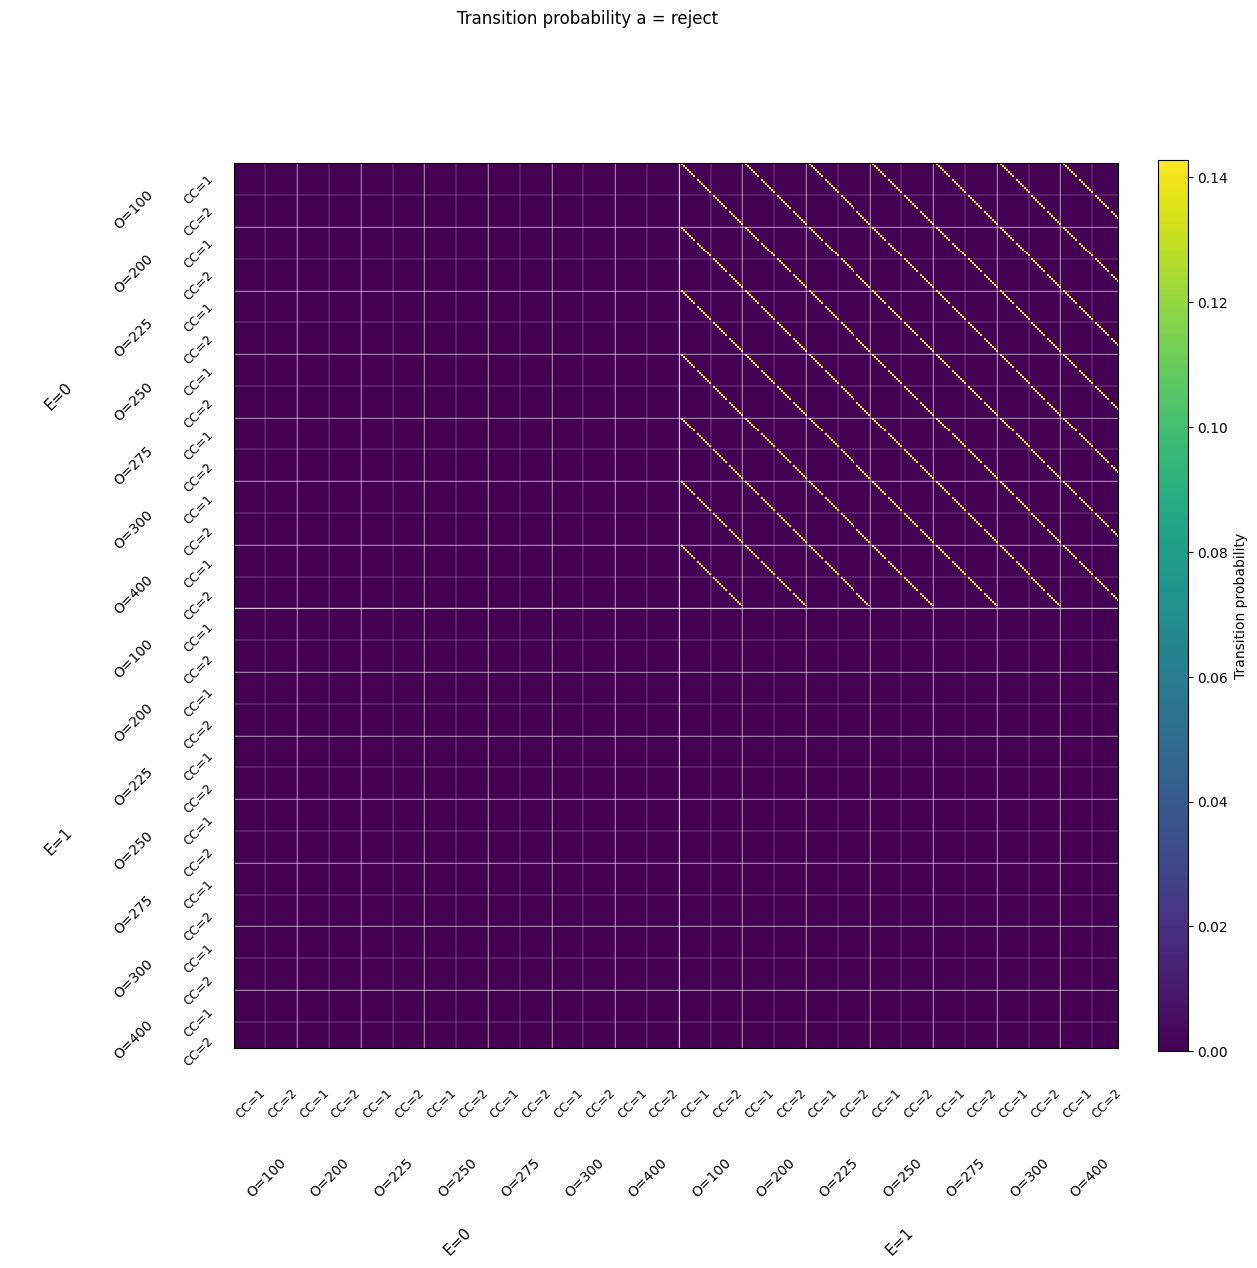

In [330]:
fig_reject = plot_state_matrix(np.squeeze(tp[0:445, 0, 0:445]), states_flat[0:445], depth=3, cmap='viridis', 
                  feature_names=["E", "O", "CC", "FC", "T"], cbar_label='Transition probability')
fig_reject.suptitle('Transition probability a = reject')
plt.show()

The y axis represents the current state and the x axis represents the next states and the states have been ordered per energy, offers, current cost, future costs and time (the two latter not being shown here). This plot is showing us that if we start at 0 energy, with a current offer of a 100, current and future costs of 1 and t = 0, then if we reject the offer, we have 7 potential future states. For all of these states, we have E=1, cc and fc remain the same, t becomes 2, and the offer can be one of the 7 options we have in our task.

The reward matrix in a very similar way tell us what the immediate reward is in each state given an action. We can also plot it:

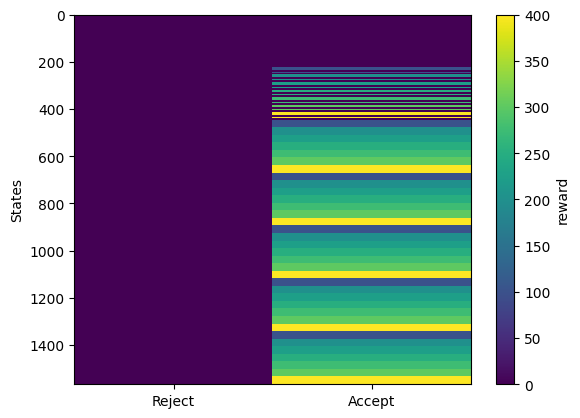

In [331]:
fig, ax = plt.subplots()
im = ax.imshow(r, aspect='auto', interpolation='none')
ax.set_ylabel('States')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Reject', 'Accept'])
# colorbar to the right
plt.colorbar(im, label='reward')
plt.show()

## Bisimulation in our task

In the previous notebook, we determined the value function based on the entire state space: we visited each states that are possible in our task, and we applied the Bellman's equation. But as we have seen above, states in an MDP are equivalent if:

$$
  \forall a \in A =
    \begin{cases}
      R(s_i, a) = R(s_j, a) \\
      P(\cdot|s_i, a) = P(\cdot|s_j, a)
    \end{cases}  
$$

It is possible that some states are actually equivalent in our task. If that is the case, we can reduce the size of the state space by aggregating equivalent states without any loss of accuracy in our optimal value function. Indeed, the value function remains the same with aggregation of equivalent states compared to using the full MDP. In fact, that's the main idea behind bismulation. So if in our task we have equivalent states, we can gain in efficiency by aggregating them together to make computation of the value function more computationally efficient. In a nutshell, that's the main research question of this project: does the brain simplify MDP by aggregating states that can be aggregated with minimal loss of accuracy in the value function. If we find evidence that that's what the brain might be doing, that will provide part of the answer of how it is able to deal with really large problem in really efficient way. The motivation being that most cognitive neuroscience research in decision making simply applies value iteration approach, despite knowing very well there is no way the brain can actually do it for problems are large as it encounters and therefor can't be the actual computational mecahnism behind decision making. Our hypothesis is that state abstraction might be part of the answer instead.

Anyhow, now that we have the transition probability and the reward matrix we can actually look whether some states fullfil the notion of equivalence described above. For that, we simply need to loop over each pairs of states and compare their reward and value functions:

In [332]:
import itertools
# Create the entire state space:
state_space = list(itertools.product(E, O, C, C, T))
# Compute all possible pairs:
states_equivalence = np.zeros([len(state_space), len(state_space)])

# Compare all possible pairs:
for i, state1 in enumerate(states_flat):
    for ii, state2 in enumerate(states_flat):
        # Extract the TP of each state:
        tp1 = tp[state_to_idx[state1], :, :]
        tp2 = tp[state_to_idx[state2], :, :]
        # Extract the reward:
        r1 = r[state_to_idx[state1], :]
        r2 = r[state_to_idx[state2], :]
        if (tp1 == tp2).all() and (r1 == r2).all():
            states_equivalence[i, ii] = 1


Just as we've plotted the TP matrix above, we can plot the state equivalence matrix that tells us for each pairs of states whether or not they are equivalent. 

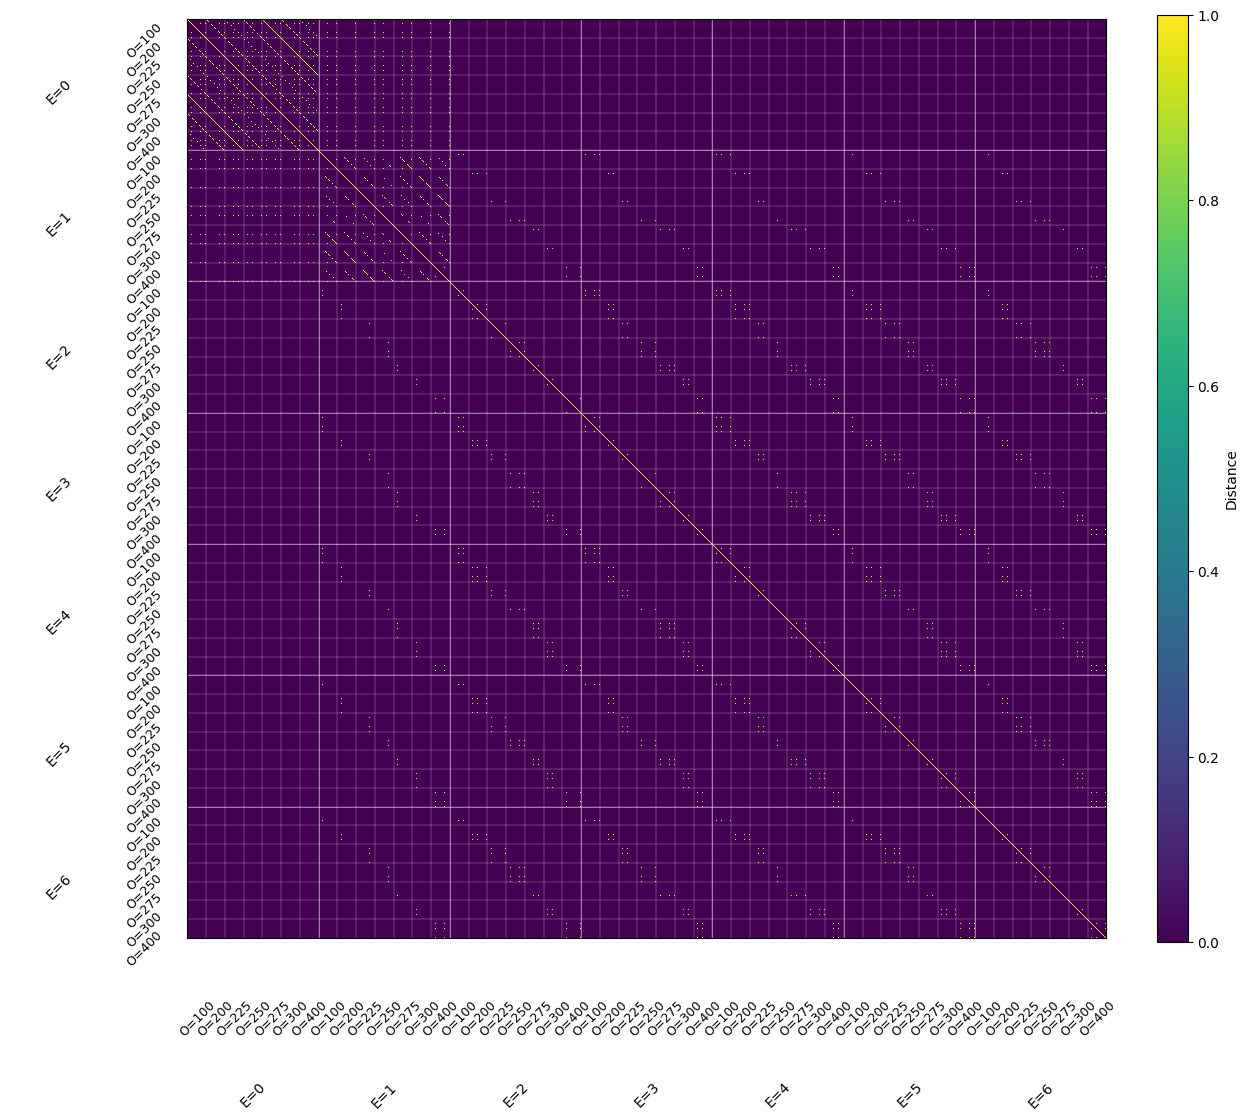

In [333]:
plot_state_matrix(states_equivalence, state_space, depth=2, cmap='viridis', 
                  feature_names=["E", "O", "CC", "FC", "T"])
plt.show()

As we can see, in our task, we have a few states that are fully equivalent. Along the diagonal are comparison of states to themselves, so it is to be expected that they are equivalent. But on the top left, we can see that we have some off diagonal patterns, revealing that certain states are equivalent. The states have been ordered by energy, offers, current and future cost and time, which means that on the top left are the low energy states. It intuitively make sense that some states when we have low energy would collapse togehter, because no matter the action, the outcome is always the same if our energy is below the cost. But let's dig into it more closely to try and characterize the clusters:

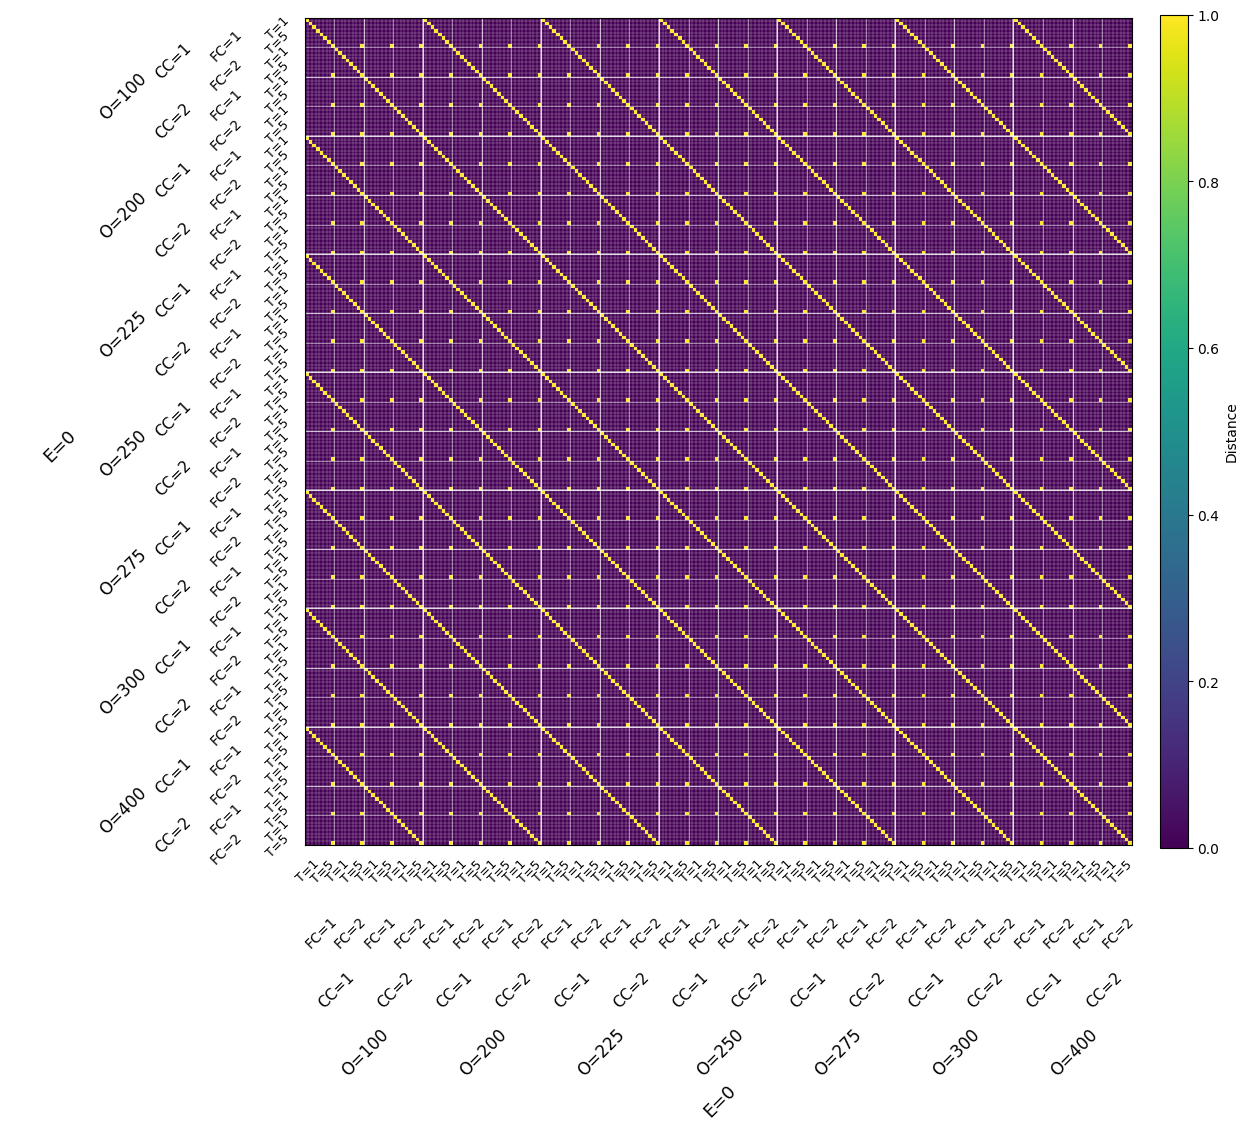

In [334]:
plot_state_matrix(states_equivalence[0:len(O) * len(C) * len(C) * len(T), 0:len(O) * len(C) * len(C) * len(T)], state_space[0:len(O) * len(C) * len(C) * len(T)], 
                  depth=5, cmap='viridis', 
                  feature_names=["E", "O", "CC", "FC", "T"])
plt.show()

We can see from the above that the top left state (e=0, o=100, cc=1, fc=1, t=1) is equivalent to the state (e=0, o=200, cc=1, fc=1, t=1). Let's think about it for a minute. If we consider the transition probability of the first state, we have the following:

For $S_t = [e=0, o=100, cc=1, fc=1, t=1]$, the next possible states are:
- $P([e=1, o \in O, cc=1, fc=1, t=2]|S_t, a=reject)=1/7$: In other words, we have 1/7 chances of landing on each reward state, while the next state time points will be 2, and the next state energy level will be 1
- $P([e=0, o \in O, cc=1, fc=1, t=2]|S_t, a=accept)=1/7$: In other words, we have 1/7 chances of landing on each reward state, while the next state time points will be 2, and the next state energy level will still be 0 because we have accepted without enough energy
In comparison, the transition probability from $S_t = e=0, o=200, cc=1, fc=1, t=1$ are:
- $P([e=1, o \in O, cc=1, fc=1, t=2]|S_t, a=reject)=1/7$: We have 1/7 chances of landing on each reward state, while the next state time points will be 2, and the next state energy level will still be 1
- $P([e=0, o \in O, cc=1, fc=1, t=2]|S_t, a=accept)=1/7$: We have 1/7 chances of landing on each reward state, while the next state time points will be 2, and the next state energy level will still be 0 because we have accepted without enough energy

The transition probabilities in both cases are the same. When considering the immediate reward, it is in both cases 0 regardless of the decision, because there is not enough energy to accept. Accordingly, these two states are equivalent. In addition, the state  $S_t = [e=0, o=100, cc=1, fc=1, t=1]$ is also equivalent to $S_t = [e=0, o=225, cc=1, fc=1, t=1]$,  $S_t = [e=0, o=00, cc=1, fc=1, t=1]$, $S_t = [e=0, o=250, cc=1, fc=1, t=1]$,  $S_t = [e=0, o=00, cc=1, fc=1, t=1]$ and so on.

Now if we move the starting state with energy level of 1, we see the following:

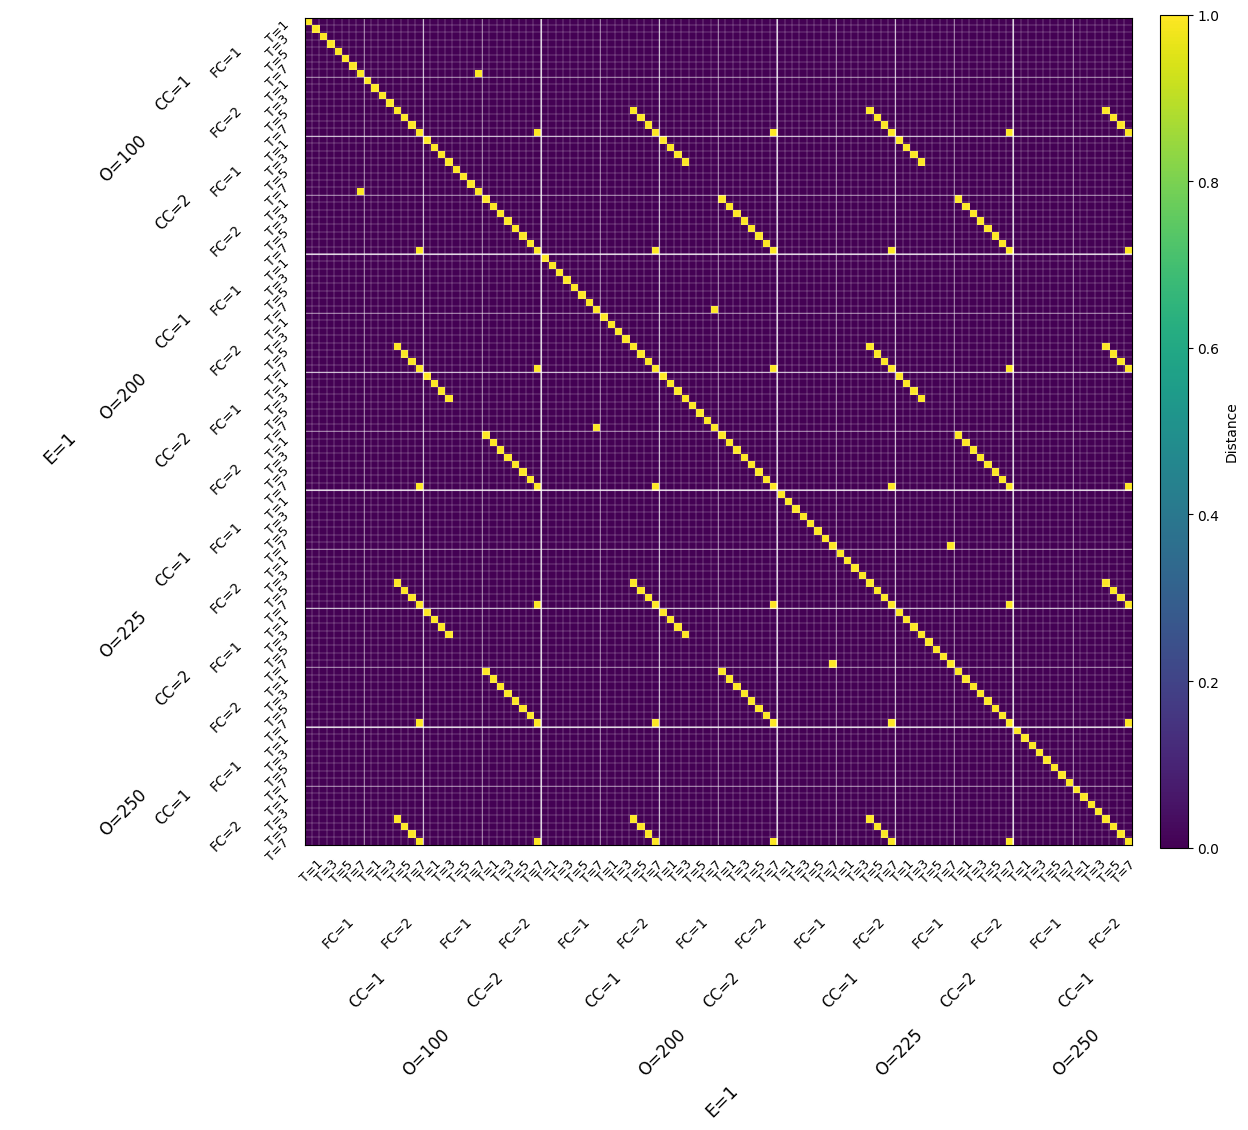

In [335]:
n_states_per_energy = len(O) * len(C) * len(C) * len(T)
plot_state_matrix(states_equivalence[n_states_per_energy:int(n_states_per_energy+n_states_per_energy/2), n_states_per_energy:int(n_states_per_energy+n_states_per_energy/2)], state_space[n_states_per_energy:int(n_states_per_energy+n_states_per_energy/2)], 
                  depth=5, cmap='viridis', 
                  feature_names=["E", "O", "CC", "FC", "T"])
plt.show()

There, things look a bit different, a bit less symetrical than before. That's to be expected, because whether or not we can accept the reward in the current state depends on the energy cost and therefore the trial number. And so, the transitional probability to the next state also depends on that. We still have equvalent states though. 

For example, the state $S=[e=1,o=100, cc=1, fc=2, t=5]$ is equivalent to the state $S=[e=1,o=200, cc=1, fc=2, t=5]$. Once again, let's see why that's the case:

For $S_t = [e=0, o=100, cc=1, fc=2, t=5]$, the next possible states are:
- $P([e=1, o \in O, cc=1, fc=2, t=6]|S_t, a=reject)=1/7$: we have 1/7 chances of landing on each reward state, while the next state time points will be 6, and the next state energy level will still be 0
- $P([e=0, o \in O, cc=1, fc=2, t=6]|S_t, a=accept)=1/7$: we have 1/7 chances of landing on each reward state, while the next state time points will be 6, and the next state energy level will still be 0 because we have accepted without enough energy
In comparison, the transition probability from $S_t = e=0, o=200, cc=1, fc=1, t=1$ are:
- $P([e=1, o \in O, cc=1, fc=2, t=6]|S_t, a=reject)=1/7$: We have 1/7 chances of landing on each reward state, while the next state time points will be 2, and the next state energy level will still be 0
- $P([e=0, o \in O, cc=1, fc=2, t=6|S_t, a=accept])=1/7$: We have 1/7 chances of landing on each reward state, while the next state time points will be 2, and the next state energy level will still be 0 because we have accepted without enough energy

Once again, in both cases, the reward is 0 in both cases, regardless of whether we accept, because the energy is too low compared to the future segment costs. 

We can further see the converse is true when we are in an early trial but the current cost is 2: $S=[e=1, o=100, cc=2, fc=1, t=1]$ is equivalent to the state $S=[e=1,o=200, cc=2, fc=1, t=1]$. 


## Identifying equivalent clusters

We can see from the plots above that there are quite a few states that are equivalent to each other. What we need is to cluster together all the states that are equivalent to one another. However, the above plots only inform us about pairwise equivalent. We need to cluster all the pairs that are equivalent to each other in a group to see if we can make sense of what's binding them together. This can be achieved quite simply by finding for each state which are all of the states that are equivalent to it. All states that are equivalent to one state are also equivalent to each other by definition

In [336]:
states_cluster = []
for i in range(states_equivalence.shape[0]):
    # Skipping states that are already part of a cluster:
    if idx_to_state[i] in list(itertools.chain.from_iterable(states_cluster)):
        continue
    cluster = [idx_to_state[idx] for idx in np.where(np.squeeze(states_equivalence[i, :]) == 1)[0]]
    if len([idx_to_state[idx] for idx in np.where(np.squeeze(states_equivalence[i, :]) == 1)[0]]) > 1:
        states_cluster.append([idx_to_state[idx] for idx in np.where(np.squeeze(states_equivalence[i, :]) == 1)[0]])

# We can now print each cluster:
for i, cluster in enumerate(states_cluster):
    print(f"States in cluster {i}: ")
    for state in cluster:
        print(f'[e={state[0]}, o={state[1]}, cc={state[2]}, fc={state[3]}, t={state[4]}]')
        

States in cluster 0: 
[e=0, o=100, cc=1, fc=1, t=1]
[e=0, o=200, cc=1, fc=1, t=1]
[e=0, o=225, cc=1, fc=1, t=1]
[e=0, o=250, cc=1, fc=1, t=1]
[e=0, o=275, cc=1, fc=1, t=1]
[e=0, o=300, cc=1, fc=1, t=1]
[e=0, o=400, cc=1, fc=1, t=1]
States in cluster 1: 
[e=0, o=100, cc=1, fc=1, t=2]
[e=0, o=200, cc=1, fc=1, t=2]
[e=0, o=225, cc=1, fc=1, t=2]
[e=0, o=250, cc=1, fc=1, t=2]
[e=0, o=275, cc=1, fc=1, t=2]
[e=0, o=300, cc=1, fc=1, t=2]
[e=0, o=400, cc=1, fc=1, t=2]
States in cluster 2: 
[e=0, o=100, cc=1, fc=1, t=3]
[e=0, o=200, cc=1, fc=1, t=3]
[e=0, o=225, cc=1, fc=1, t=3]
[e=0, o=250, cc=1, fc=1, t=3]
[e=0, o=275, cc=1, fc=1, t=3]
[e=0, o=300, cc=1, fc=1, t=3]
[e=0, o=400, cc=1, fc=1, t=3]
States in cluster 3: 
[e=0, o=100, cc=1, fc=1, t=4]
[e=0, o=200, cc=1, fc=1, t=4]
[e=0, o=225, cc=1, fc=1, t=4]
[e=0, o=250, cc=1, fc=1, t=4]
[e=0, o=275, cc=1, fc=1, t=4]
[e=0, o=300, cc=1, fc=1, t=4]
[e=0, o=400, cc=1, fc=1, t=4]
States in cluster 4: 
[e=0, o=100, cc=1, fc=1, t=5]
[e=0, o=200, cc=1, f

In [337]:
# Calculate the proportion of redundant states:
n_clusters = len(states_cluster)
n_states_in_clusters = len(list(itertools.chain.from_iterable(states_cluster)))
print(f'Results of states clustering: ')
print(f'     Number of clusters: {n_clusters}')
print(f'     Number of states in clusters: {n_states_in_clusters} out of {states_equivalence.shape[0]}')
print(f'     Reduced state space: {n_clusters + states_equivalence.shape[0] - n_states_in_clusters}')
print(f'     Relative state space reduction: {(n_clusters + states_equivalence.shape[0] - n_states_in_clusters) / n_clusters}')

Results of states clustering: 
     Number of clusters: 50
     Number of states in clusters: 490 out of 1568
     Reduced state space: 1128
     Relative state space reduction: 22.56


We have a total of 50 clusters, that contain a total of 490 states, which implies that 490 states were equivalent to at least one other state. That's a reduction of roughly 23% of the number of states in our state space. 

## State abstraction limitations
The method we have applied is fairly simple and enables to reduce the state space, such that computation of the optimal policy goes faster. But there is an important limitation of the method we have applied. As much as it makes computation of the optimal policy faster, it requires to first compare each state to all other possible states. In other words, we need to make pairwise comparison. Unfortunately, the number of pairs grows polynomially with the number of states in our state space, so it is $O(N^2)$. In fact the computational complexity of comparing all states against each other is about as high as computing the optimal policy using value iteration. So it's not really gaining time, it's just kicking the computational can up the road so to speak. 

As it turns out, there are many various methods that have been developped to make the identification of similar states faster, such that there is actual a huge computational benefit in doing so compared to actually doing backward induction on the full MDP. 

So if we go back to our original question, we just want to know whether the brain does state abstraction, not which clever trick might be used behind the scene to make it fast. What we are after are decision values computed under abstracted, reduced MDP that differ from the optimal policy computed on the full MDP to test whether participants might be doing something like it, somehow. We can therefore compute abstraction using brute force approaches, test whether that's what might be going on the brain without making any assumption that the exact algorithm we used for abstraction is also the one employed by the brain. In other words, the computational complexity of brute force state abstraction is a limitation,but not one we actually need to be concerned abou

# Solving abstracted MDP

What we have done in the previous section is exact bisimulation, only considering states that have exactly the same TP and rewards. We will see in the next notebooks that there are approaches that can identify approximately similar states and why that's helpful. With approximate methods, we get value and state value policies that are approximately the same as what's obtained with the full MDP. But with exact methods, we actually get the exact same value and state value functions, and as a result exactly the same decision values. That's the whole advantage of it: we get a smaller representation of the MDP that is guaranteed to give us the best possible solution. 

To verify that that is indeed the case, we can compute the decision values from the reduced MDP and compare it to the full MDP to make sure that they are equal.

# Notes
<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) In fact, we could revise the code we had before by first computing the full matrix $P$ and from each state multiply the transition proba from the current state to all others to the value function we had and that would be it, not need to go into a separate function. Note that one of the reason for us not to do it like that is for memory efficiency. The full transition probability matrix gets quite large quite quick, and it contains a lot of 0 entries which won't affect the computations. So it is much easier to compute non-zero transitional probabilities on the fly. 

# Bibliography
<a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) Li, L., Walsh, T. J., & Littman, M. L. (2006). Towards a unified theory of state abstraction for MDPs. AI&M, 1(2), 3.
<a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) Givan, R., Dean, T., & Greig, M. (2003). Equivalence notions and model minimization in Markov decision processes. Artificial intelligence, 147(1-2), 163-223.
<a name="bib_ref-3"></a>[<sup>[1]</sup>](#bib_ref-3) Dean, T., & Givan, R. (1997, July). Model minimization in Markov decision processes. In AAAI/IAAI (pp. 106-111).